# Step 4: Model Development

---

Appropriate machine learning algorithms for classification problems like ours includes:

- Logistic Regression
- Decision Tree
- Random Forest
- k-Nearest Neighbors
- Support Vector Machine
- Naive Bayes

Considering the small number of samples in our dataset, the number of features, the binary nature of our problem, and the assignment constraints, we will develop and pick out the best algorithms among these 4:

- Logistic Regression
- Decision Tree
- Bagged Trees
- Random Forest

For individual model's performance evaluation, we will be using [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) to measure our models' performance and optimize them. While every sepsis case needs immediate attention, thus every potential sepsis patient needs close monitering, false positive predictions might take medical resources away from patients that might actually need it. In subsequent model development, if we see that recall and precision have different weights in our problem domain, we can switch to [F-beta](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html#:~:text=The%20F-beta%20score%20is,recall%20in%20the%20combined%20score.) instead.

To get this performance, we will use K-Fold cross validation.

For regularization, we will be using Grid Search method to select and fine tune our hyperparameters.

To compare between the different model of different algorithms, we will use both $F_1$ score and [ROC-AUC](https://www.youtube.com/watch?v=4jRBRDbJemM). This will be done after we have developed our models.

---

**Table of Contents**

1. [Data Splitting](#data)
2. [Logistic Regression](#logistic)
3. [Decision Tree](#tree)
4. [Bagged Trees](#bagged-trees)
5. [Random Forest](#forest)

In [1]:
# Imports and environment setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve


# Custom utils functions
from utils.visualization import show_train_val_confusion_matrix
from utils.visualization import visualize_training

We will store our developed models and their performance in the following variables:

In [2]:
clfs = dict()

## 1. Data Splitting<a id="data"></a>

For this section, we are using the processed datasets from [Step 3. Data Processing](Step3.DataProcessing.ipynb).

In [3]:
df_train = pd.read_csv("../data/processed_train.csv")
df_test = pd.read_csv("../data/processed_test.csv")

In [4]:
df_test.info()
df_test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRG     169 non-null    float64
 1   PL      169 non-null    float64
 2   PR      169 non-null    float64
 3   SK      169 non-null    float64
 4   TS      169 non-null    float64
 5   M11     169 non-null    float64
 6   BD2     169 non-null    float64
 7   Age     169 non-null    float64
dtypes: float64(8)
memory usage: 10.7 KB


,PRG,PL,PR,SK,TS,M11,BD2,Age
count,1.690000e+02,1.690000e+02,1.690000e+02,1.690000e+02,1.690000e+02,1.690000e+02,1.690000e+02,1.690000e+02
mean,1.156209e-16,-3.310961e-16,-1.734313e-16,-8.146015e-17,-6.832142e-17,-1.072121e-15,5.255494e-17,-1.072121e-15
std,1.002972e+00,1.002972e+00,1.002972e+00,1.002972e+00,1.002972e+00,1.002972e+00,1.002972e+00,1.002972e+00
min,-1.208521e+00,-3.241433e+00,-4.708929e+00,-1.474053e+00,-9.760584e-01,-8.063583e+00,-1.980105e+00,-1.245210e+00
25%,-1.207359e+00,-6.956845e-01,2.720883e-02,-1.474053e+00,-9.760584e-01,-2.507388e-01,-7.312326e-01,-8.293165e-01
50%,6.858171e-02,-5.691907e-03,2.302438e-01,5.313517e-01,-9.760584e-01,1.268218e-01,-5.861043e-02,-3.491998e-01
75%,8.739056e-01,6.789913e-01,3.197079e-01,7.425575e-01,9.923200e-01,4.138384e-01,7.819177e-01,9.136708e-01
max,1.772338e+00,2.141800e+00,7.261358e-01,1.015063e+00,1.548606e+00,1.469355e+00,2.445566e+00,2.504717e+00


In [5]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRG     782 non-null    float64
 1   PL      782 non-null    float64
 2   PR      782 non-null    float64
 3   SK      782 non-null    float64
 4   TS      782 non-null    float64
 5   M11     782 non-null    float64
 6   BD2     782 non-null    float64
 7   Age     782 non-null    float64
 8   Sepsis  782 non-null    float64
dtypes: float64(9)
memory usage: 55.1 KB


,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepsis
count,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.00000
mean,0.093303,0.120884,0.053327,0.066275,0.094252,0.079220,0.081804,0.107794,0.50000
std,0.981172,0.991983,1.024143,0.972240,0.993948,0.979384,1.007280,1.002119,0.50032
min,-1.739748,-3.875880,-3.277139,-3.720660,-1.784871,-2.680662,-2.664330,-1.288830,0.00000
25%,-0.756075,-0.554200,-0.471875,-0.524925,-0.325599,-0.588994,-0.642949,-0.713537,0.00000
50%,0.164328,0.120653,0.097826,-0.066467,-0.325599,0.143147,0.133515,-0.003753,0.50000
75%,0.803661,0.835510,0.787667,0.786756,0.522600,0.726554,0.911406,0.918774,1.00000
max,1.787925,2.066296,2.182884,2.050475,1.652611,2.195947,1.855361,2.256671,1.00000


In [6]:
# Separate our features (X) and target (y)
df_X = df_train.drop(["Sepsis"], axis=1)
df_y = df_train[["Sepsis"]]

# Splitting our training data into a train set and a validation set
train_X, val_X, train_y, val_y = train_test_split(
    df_X, df_y,
    shuffle=True,
    random_state=0,  # Ensure reproducible results
    test_size=0.2    # 80% Train - 20% Validation
)

print(f"train_X shape: {train_X.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"val_X shape: {val_X.shape}")
print(f"val_y shape: {val_y.shape}")

train_X shape: (625, 8)
train_y shape: (625, 1)
val_X shape: (157, 8)
val_y shape: (157, 1)


Setting up K-Fold cross validation for our models:

In [7]:
cv = KFold(
    n_splits=4,     # Each fold is 20% of df_X
    shuffle=True,
    random_state=0  # Reproducible result
)

## 2. Logistic Regression<a id="logistic"></a>

We would develop and evaluate the following models:

- Logistic Regression with Linear Features;
- Logistic Regression with Polynomial Features of degree 2;
- Logistic Regression with Polynomial Features of degree 3;
- Logistic Regression with Polynomial Features of degree 4.

We are experimenting with both $L_1$ (lasso) and $L_2$ (ridge) regularization to find out which method is more appropriate. And although findings in [Step 1. EDA](Step1.EDA.ipynb) suggest that we stop at Polynomial Features of degree 3, we are still experimenting with degree 4 because we introduced regularization into our Logistic Regression model. However, we will not go any higher than degree 4, since it is too computationally expensive.

In [8]:
clf = LogisticRegression(
    solver="liblinear",       # Good for our small dataset
    class_weight="balanced",
    max_iter=1_000,
    random_state=0            # Reproducible result
)

### 2.1. Hyperparameters

- Regularization strength $\lambda$ (lambda)
- Regularization type: $L_1$ or $L_2$

In [9]:
params = {
    "C": 1 / np.logspace(-5, 2, num=100),
    "penalty": ["l1", "l2"]
}

### 2.2. Logistic Regression with Linear Features

In [10]:
grid_clf = GridSearchCV(clf, params, cv=cv, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
grid_clf.fit(train_X, train_y.values.ravel())

train_pred_y = grid_clf.predict(train_X)
val_pred_y = grid_clf.predict(val_X)
clfs["logistic1"] = grid_clf

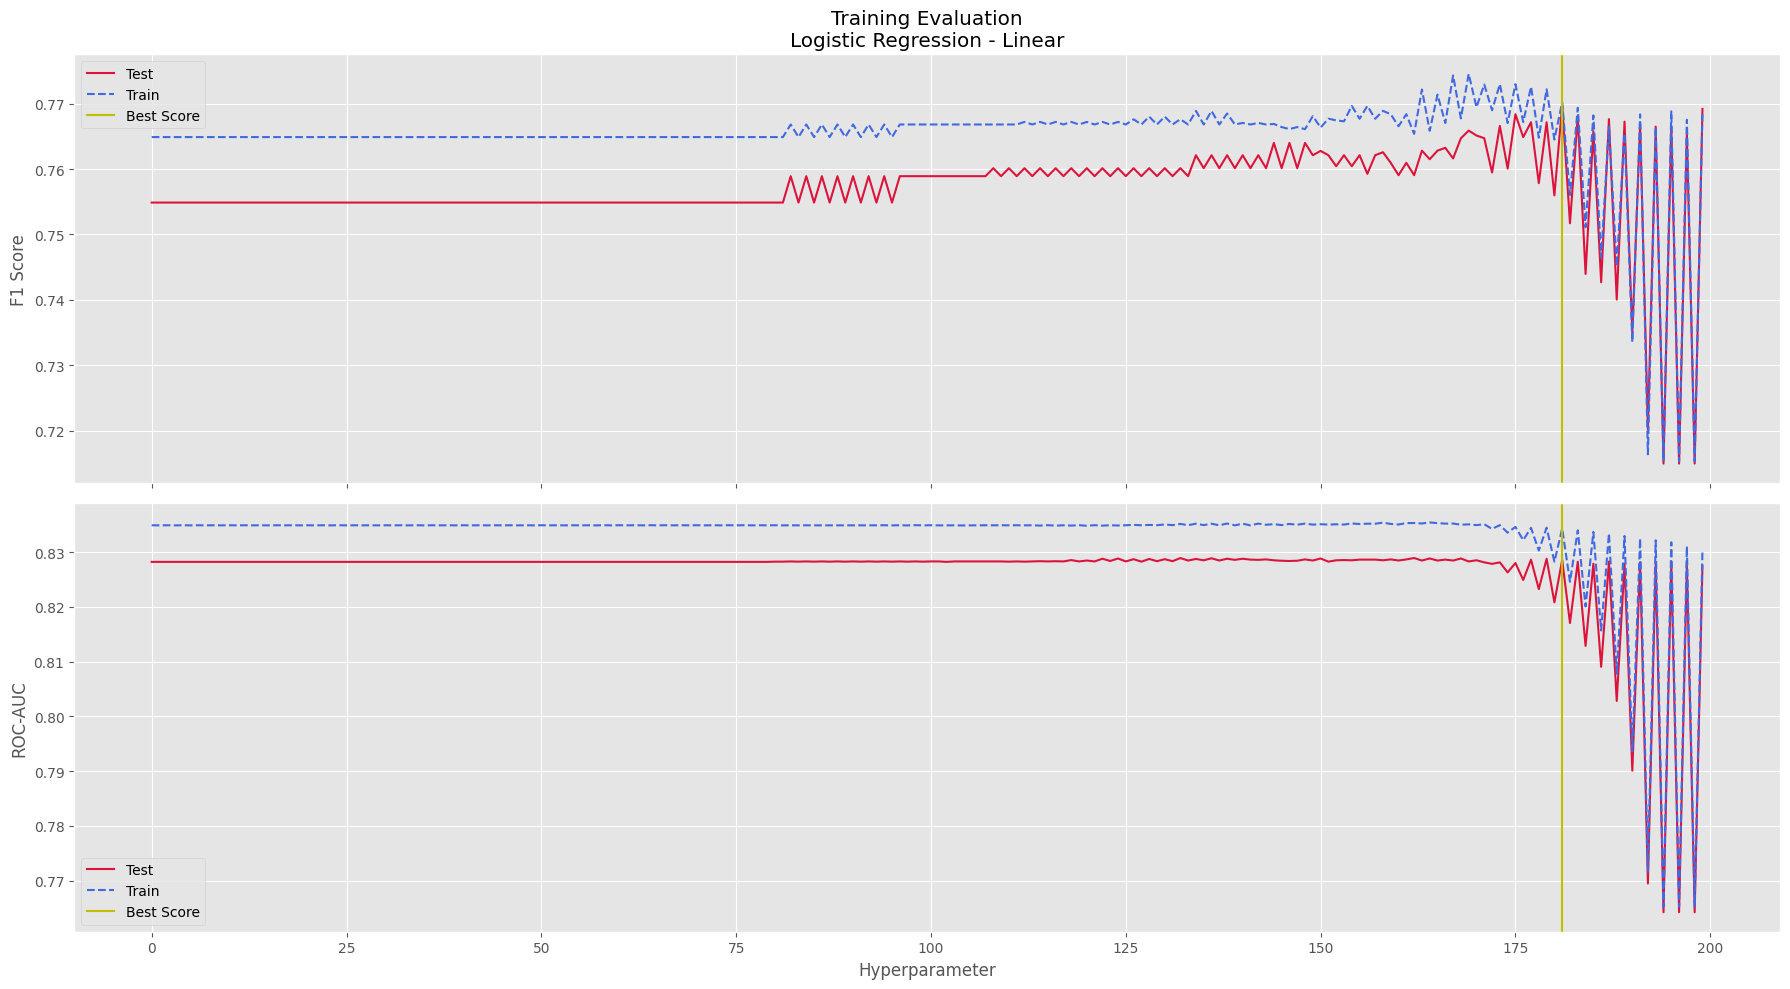

In [11]:
visualize_training(grid_clf, "Training Evaluation\nLogistic Regression - Linear", "../images/ModelDev_Logistic1_TrainValCompare.png")

In [12]:
grid_clf.best_params_

{'C': 0.04328761281083062, 'penalty': 'l2'}

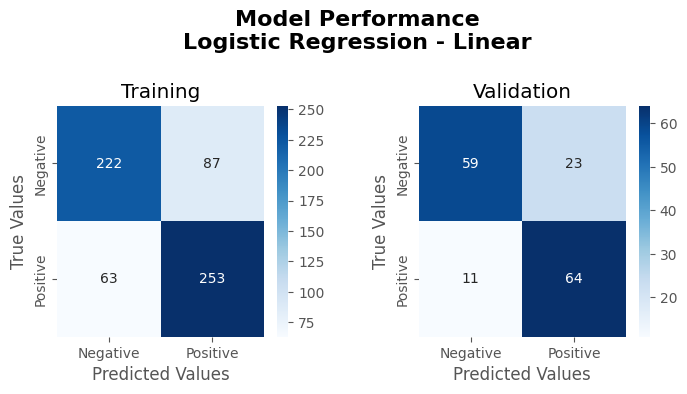

╔═══════════════════════════════════════════════════╗
║               TRAINING PERFORMANCE                ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.78      0.72      0.75       309
         1.0       0.74      0.80      0.77       316

    accuracy                           0.76       625
   macro avg       0.76      0.76      0.76       625
weighted avg       0.76      0.76      0.76       625

╔═══════════════════════════════════════════════════╗
║              VALIDATION PERFORMANCE               ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.84      0.72      0.78        82
         1.0       0.74      0.85      0.79        75

    accuracy                           0.78       157
   macro avg       0.79      0.79      0.78       157
weighted avg       0.79      0.78      0.78       157



In [13]:
show_train_val_confusion_matrix(train_y, train_pred_y, val_y, val_pred_y, "Model Performance\nLogistic Regression - Linear", "../images/ModelDev_Logistic1_CM.png")

### 2.3. Logistic Regression with 2nd Order Polynomial Features

In [14]:
# Degree 2 Polynomial Features:
poly = PolynomialFeatures(2)
train_X_poly2 = poly.fit_transform(train_X)
val_X_poly2 = poly.transform(val_X)

# We need to scale the data again after transforming it to polynomial features
scaler = StandardScaler()
train_X_poly2 = scaler.fit_transform(train_X_poly2)
val_X_poly2 = scaler.transform(val_X_poly2)

In [15]:
grid_clf = GridSearchCV(clf, params, cv=cv, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
grid_clf.fit(train_X_poly2, train_y.values.ravel())

train_pred_y = grid_clf.predict(train_X_poly2)
val_pred_y = grid_clf.predict(val_X_poly2)
clfs["logistic2"] = grid_clf

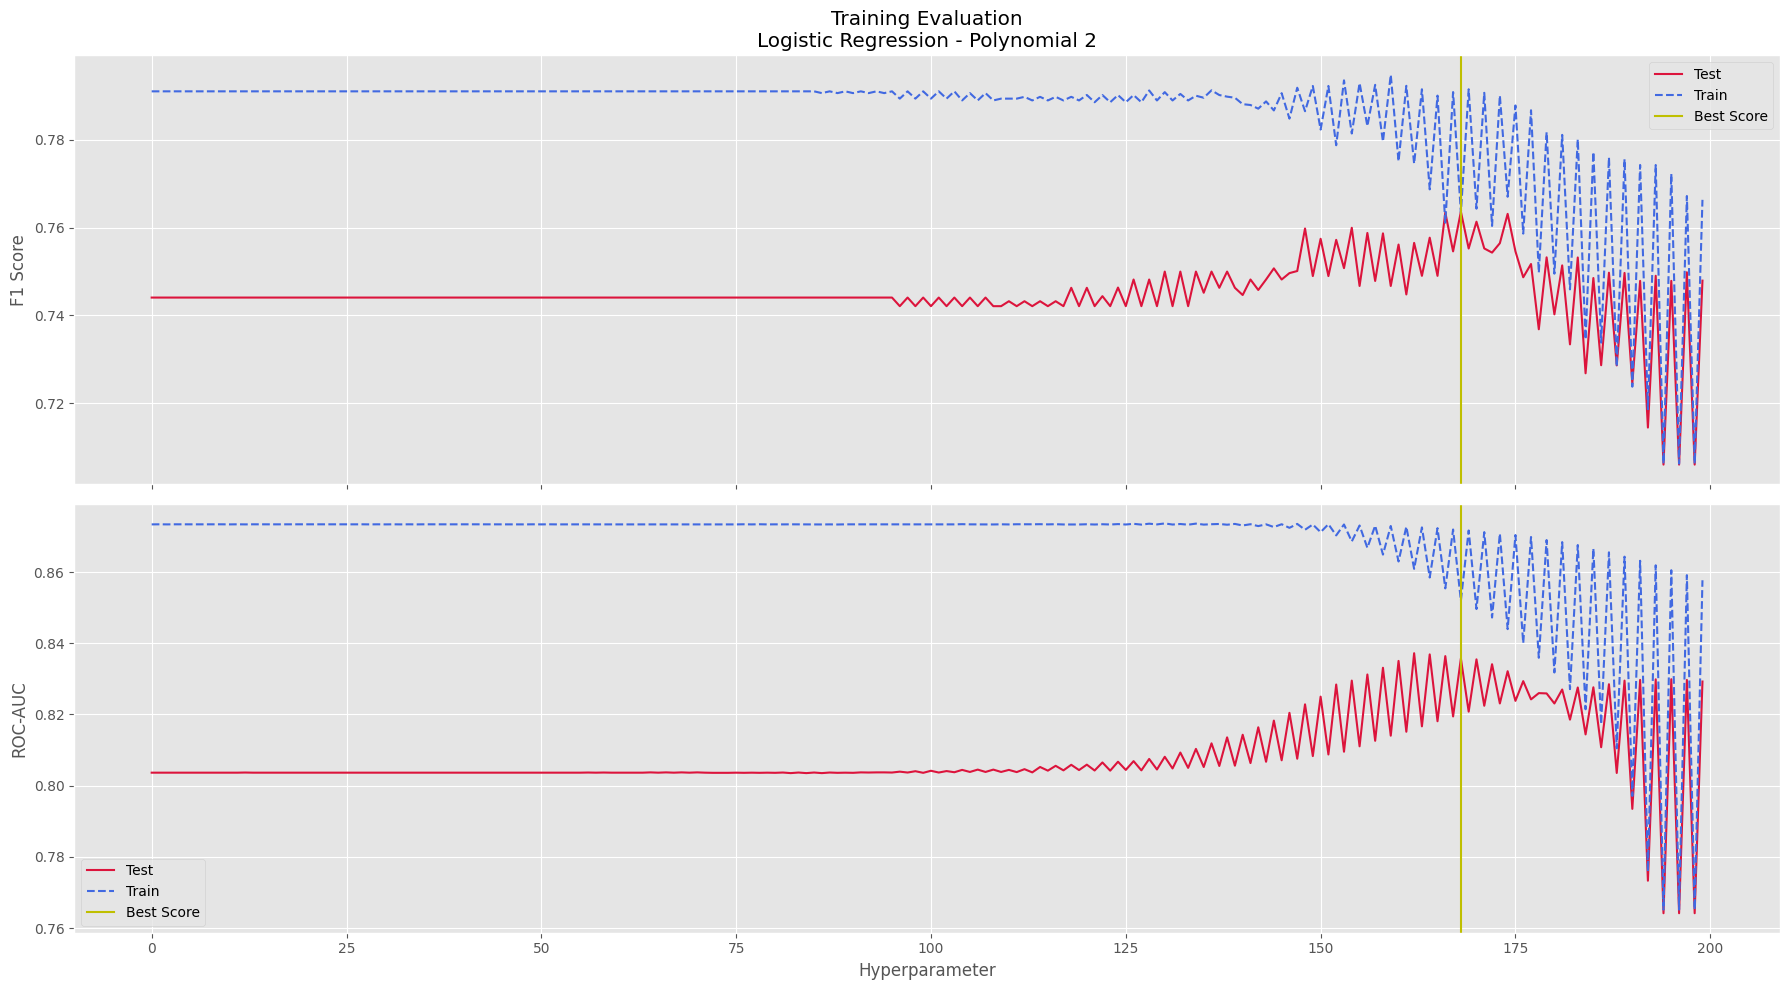

In [16]:
visualize_training(grid_clf, "Training Evaluation\nLogistic Regression - Polynomial 2", "../images/ModelDev_Logistic2_TrainValCompare.png")

In [17]:
grid_clf.best_params_

{'C': 0.11497569953977356, 'penalty': 'l1'}

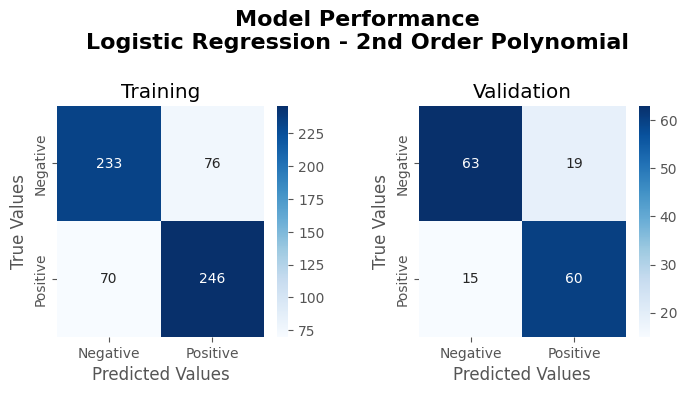

╔═══════════════════════════════════════════════════╗
║               TRAINING PERFORMANCE                ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76       309
         1.0       0.76      0.78      0.77       316

    accuracy                           0.77       625
   macro avg       0.77      0.77      0.77       625
weighted avg       0.77      0.77      0.77       625

╔═══════════════════════════════════════════════════╗
║              VALIDATION PERFORMANCE               ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79        82
         1.0       0.76      0.80      0.78        75

    accuracy                           0.78       157
   macro avg       0.78      0.78      0.78       157
weighted avg       0.78      0.78      0.78       157



In [18]:
show_train_val_confusion_matrix(train_y, train_pred_y, val_y, val_pred_y, "Model Performance\nLogistic Regression - 2nd Order Polynomial", "../images/ModelDev_Logistic2_CM.png")

### 2.4. Logistic Regression with 3rd Order Polynomial Features

In [19]:
# Degree 3 Polynomial Features:
poly = PolynomialFeatures(3)
train_X_poly3 = poly.fit_transform(train_X)
val_X_poly3 = poly.transform(val_X)

# We need to scale the data again after transforming it to polynomial features
scaler = StandardScaler()
train_X_poly3 = scaler.fit_transform(train_X_poly3)
val_X_poly3 = scaler.transform(val_X_poly3)

In [20]:
grid_clf = GridSearchCV(clf, params, cv=cv, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
grid_clf.fit(train_X_poly3, train_y.values.ravel())

train_pred_y = grid_clf.predict(train_X_poly3)
val_pred_y = grid_clf.predict(val_X_poly3)
clfs["logistic3"] = grid_clf

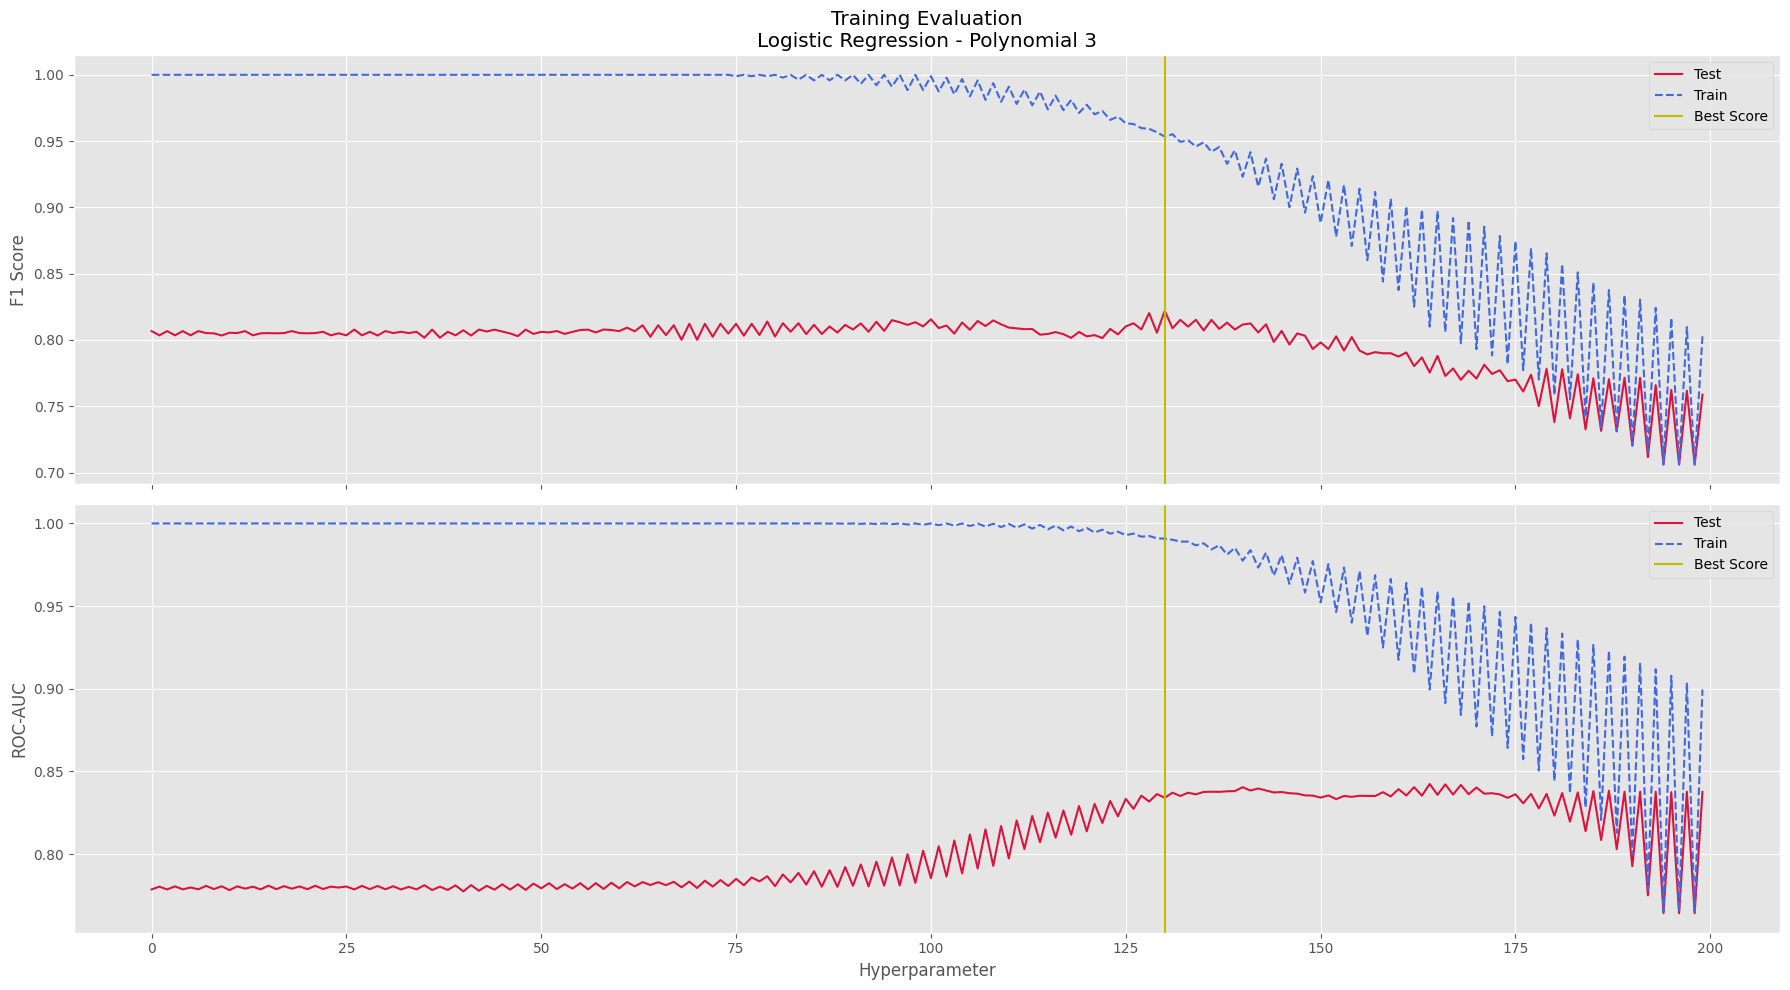

In [21]:
visualize_training(grid_clf, "Training Evaluation\nLogistic Regression - Polynomial 3", "../images/ModelDev_Logistic3_TrainValCompare.png")

In [22]:
grid_clf.best_params_

{'C': 2.5353644939701114, 'penalty': 'l1'}

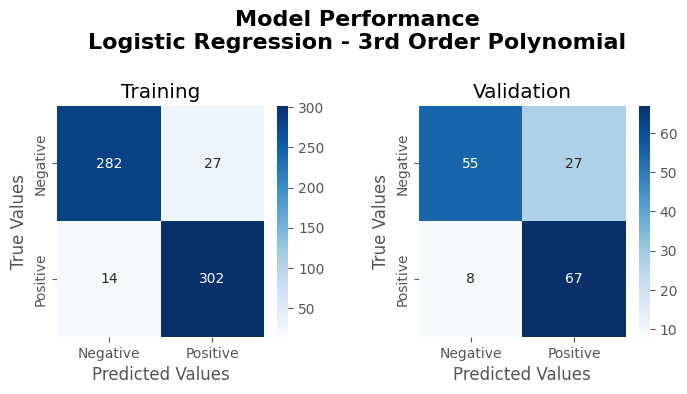

╔═══════════════════════════════════════════════════╗
║               TRAINING PERFORMANCE                ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93       309
         1.0       0.92      0.96      0.94       316

    accuracy                           0.93       625
   macro avg       0.94      0.93      0.93       625
weighted avg       0.94      0.93      0.93       625

╔═══════════════════════════════════════════════════╗
║              VALIDATION PERFORMANCE               ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.87      0.67      0.76        82
         1.0       0.71      0.89      0.79        75

    accuracy                           0.78       157
   macro avg       0.79      0.78      0.78       157
weighted avg       0.80      0.78      0.77       157



In [23]:
show_train_val_confusion_matrix(train_y, train_pred_y, val_y, val_pred_y, "Model Performance\nLogistic Regression - 3rd Order Polynomial", "../images/ModelDev_Logistic3_CM.png")

### 2.5. Logistic Regression with 4th Order Polynomial Features

In [24]:
# Degree 4 Polynomial Features:
poly = PolynomialFeatures(4)
train_X_poly4 = poly.fit_transform(train_X)
val_X_poly4 = poly.transform(val_X)

# We need to scale the data again after transforming it to polynomial features
scaler = StandardScaler()
train_X_poly4 = scaler.fit_transform(train_X_poly4)
val_X_poly4 = scaler.transform(val_X_poly4)

In [25]:
grid_clf = GridSearchCV(clf, params, cv=cv, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
grid_clf.fit(train_X_poly4, train_y.values.ravel())

train_pred_y = grid_clf.predict(train_X_poly4)
val_pred_y = grid_clf.predict(val_X_poly4)
clfs["logistic4"] = grid_clf

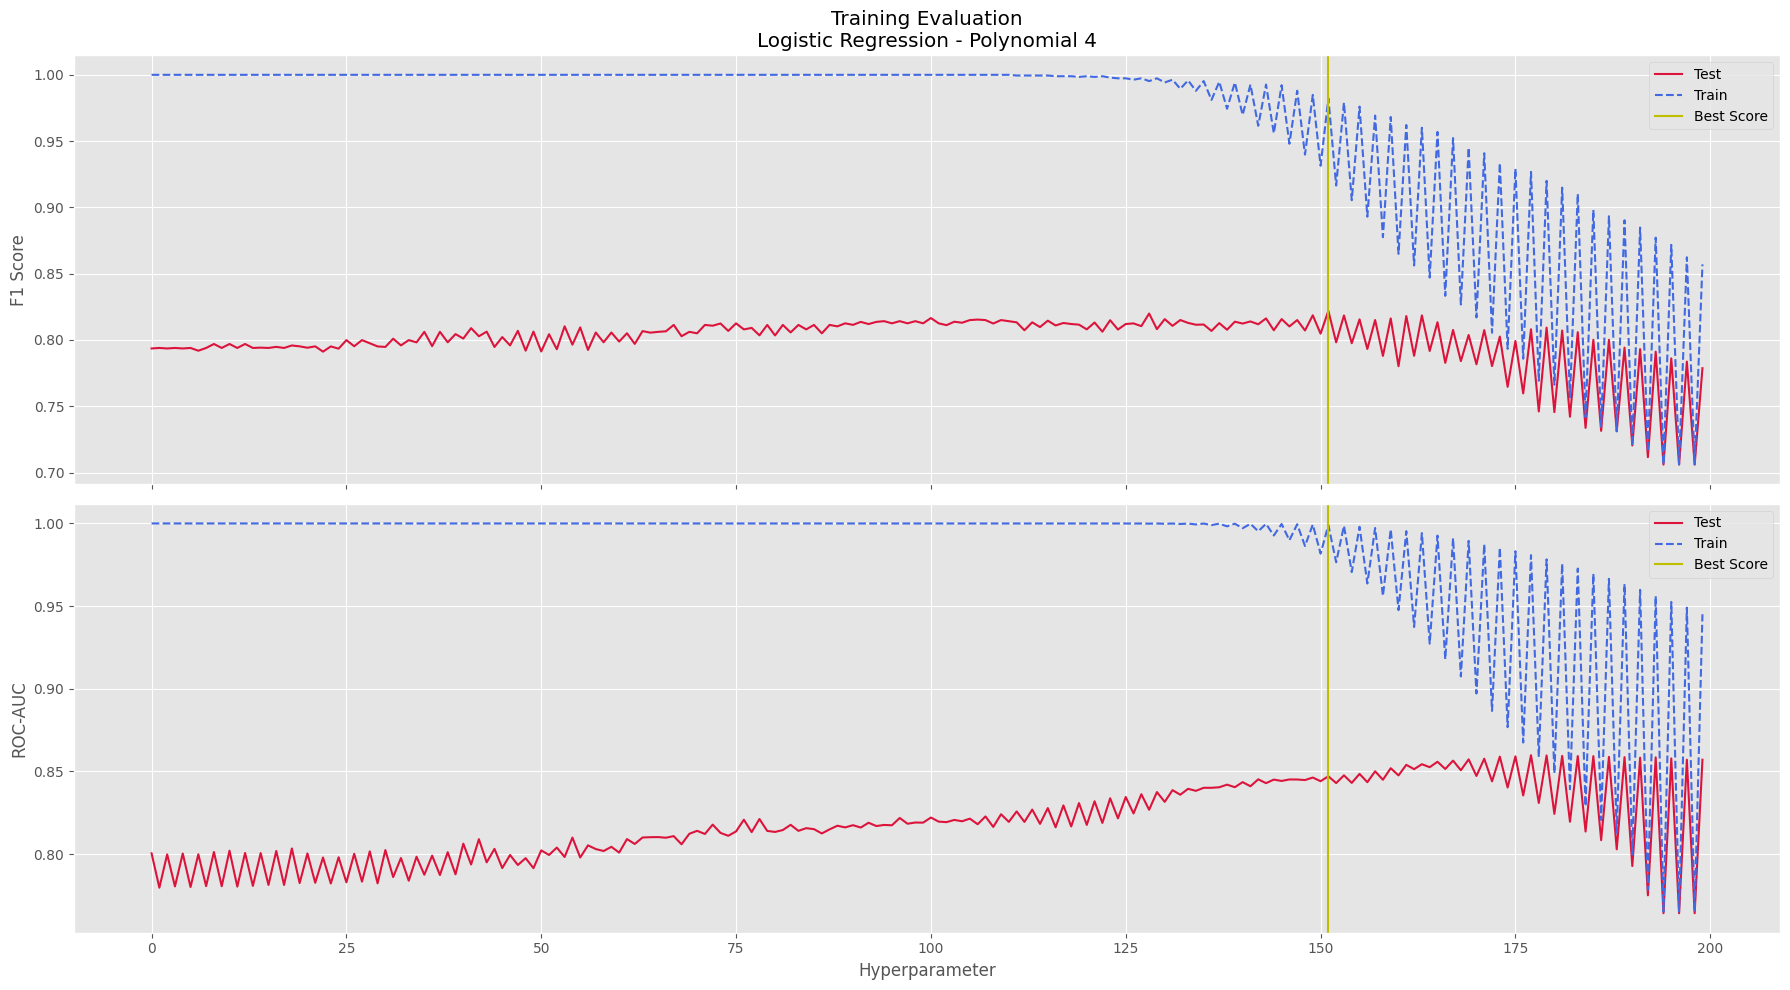

In [26]:
visualize_training(grid_clf, "Training Evaluation\nLogistic Regression - Polynomial 4", "../images/ModelDev_Logistic4_TrainValCompare.png")

In [27]:
grid_clf.best_params_

{'C': 0.49770235643321137, 'penalty': 'l2'}

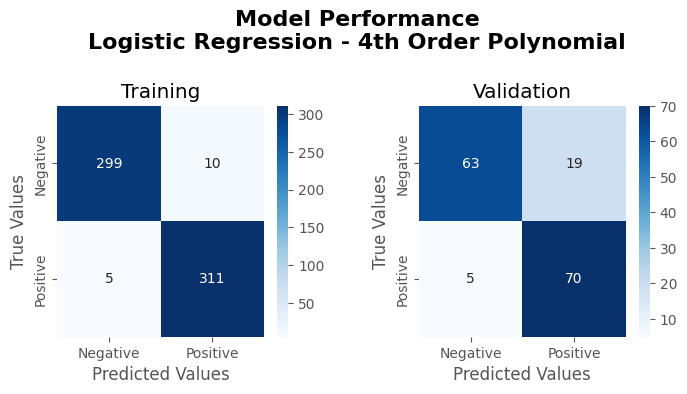

╔═══════════════════════════════════════════════════╗
║               TRAINING PERFORMANCE                ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       309
         1.0       0.97      0.98      0.98       316

    accuracy                           0.98       625
   macro avg       0.98      0.98      0.98       625
weighted avg       0.98      0.98      0.98       625

╔═══════════════════════════════════════════════════╗
║              VALIDATION PERFORMANCE               ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.93      0.77      0.84        82
         1.0       0.79      0.93      0.85        75

    accuracy                           0.85       157
   macro avg       0.86      0.85      0.85       157
weighted avg       0.86      0.85      0.85       157



In [28]:
show_train_val_confusion_matrix(train_y, train_pred_y, val_y, val_pred_y, "Model Performance\nLogistic Regression - 4th Order Polynomial", "../images/ModelDev_Logistic4_CM.png")

## 3. Decision Tree<a id="tree"></a>

### 3.1. Hyperparameters

In [29]:
params = {
    "max_depth": np.arange(2, 24, 2),
    "min_samples_split": np.arange(2, 10, 2),
}

### 3.2. Model

In [30]:
clf = DecisionTreeClassifier(
    criterion="gini",         # Good for balanced data (we have already up-sampled out data so it is now balanced)
    class_weight="balanced",
    random_state=0            # Reproducible result
)

grid_clf = GridSearchCV(clf, params, cv=cv, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
grid_clf.fit(train_X, train_y.values.ravel())

train_pred_y = grid_clf.predict(train_X)
val_pred_y = grid_clf.predict(val_X)
clfs["tree"] = grid_clf

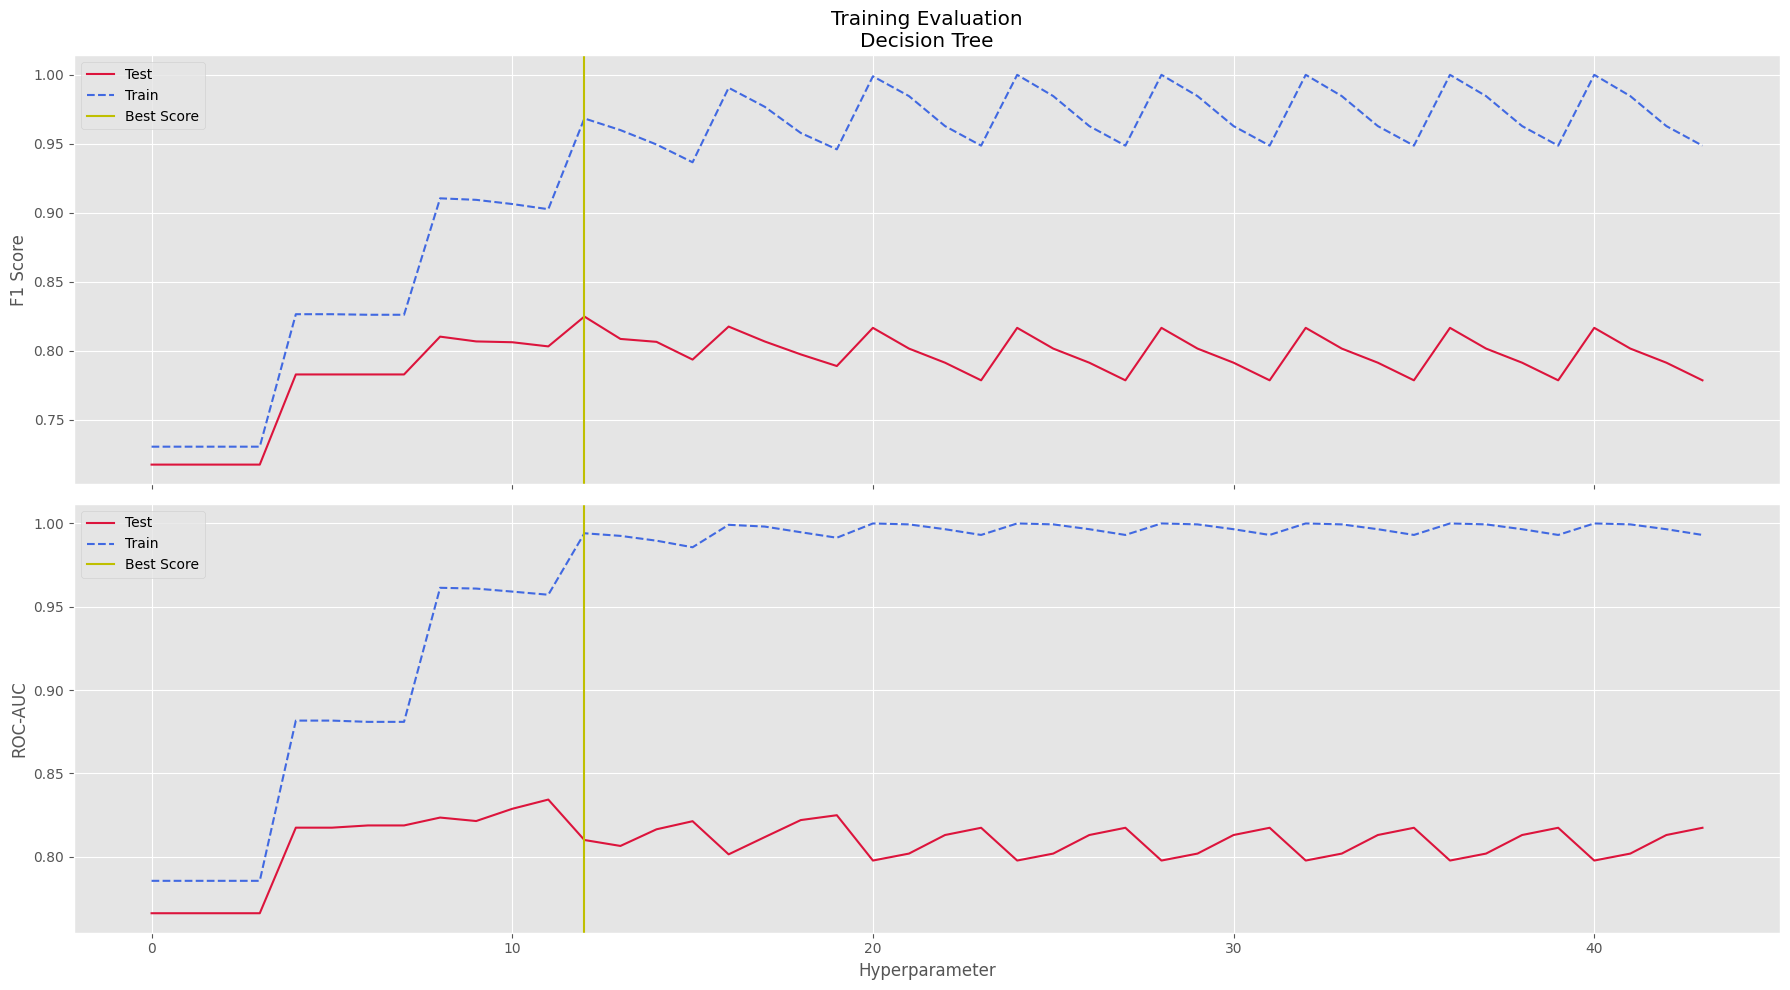

In [31]:
visualize_training(grid_clf, "Training Evaluation\nDecision Tree", "../images/ModelDev_Tree_TrainValCompare.png")

In [32]:
grid_clf.best_params_

{'max_depth': 8, 'min_samples_split': 2}

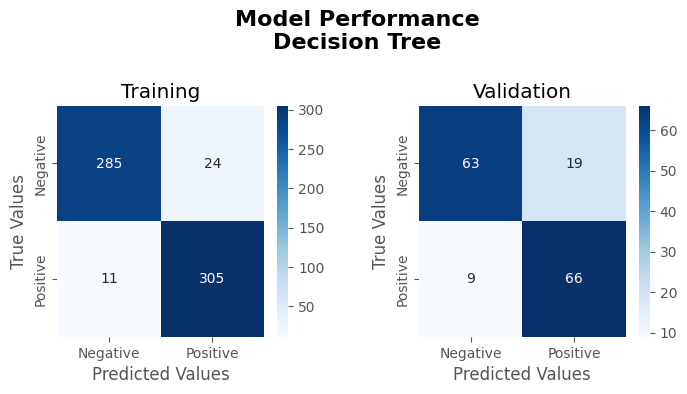

╔═══════════════════════════════════════════════════╗
║               TRAINING PERFORMANCE                ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       309
         1.0       0.93      0.97      0.95       316

    accuracy                           0.94       625
   macro avg       0.94      0.94      0.94       625
weighted avg       0.94      0.94      0.94       625

╔═══════════════════════════════════════════════════╗
║              VALIDATION PERFORMANCE               ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.88      0.77      0.82        82
         1.0       0.78      0.88      0.82        75

    accuracy                           0.82       157
   macro avg       0.83      0.82      0.82       157
weighted avg       0.83      0.82      0.82       157



In [33]:
show_train_val_confusion_matrix(train_y, train_pred_y, val_y, val_pred_y, "Model Performance\nDecision Tree", "../images/ModelDev_Tree_CM.png")

## 4. Bagged Trees<a id="bagged-trees"></a>

### 4.1. Hyperparameters

In [34]:
params = {
    "n_estimators": np.arange(5, 25, 5),
    "max_samples": np.arange(0.1, 1.0, 0.1),
}

### 4.2. Model

In [35]:
clf = BaggingClassifier(
    estimator=clfs["tree"],
    random_state=0  # Reproducible result
)

grid_clf = GridSearchCV(clf, params, cv=cv, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
grid_clf.fit(train_X, train_y.values.ravel())

train_pred_y = grid_clf.predict(train_X)
val_pred_y = grid_clf.predict(val_X)
clfs["bagged_trees"] = grid_clf

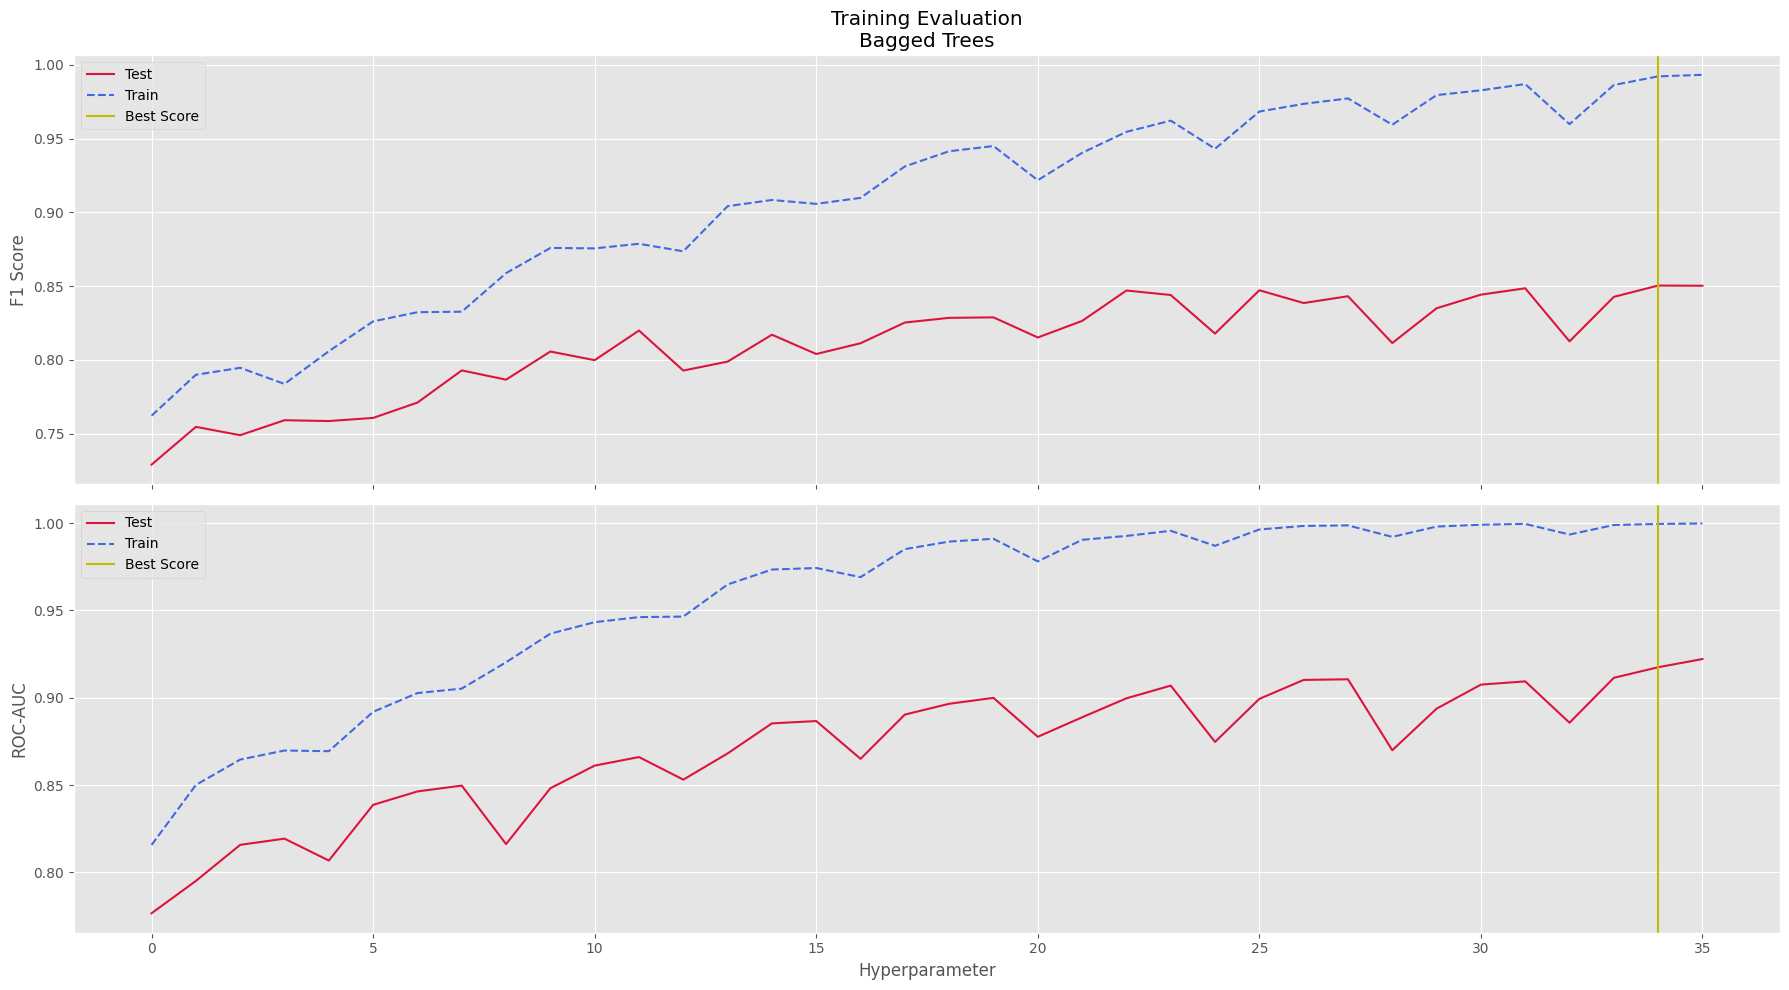

In [36]:
visualize_training(grid_clf, "Training Evaluation\nBagged Trees", "../images/ModelDev_BaggedTrees_TrainValCompare.png")

In [37]:
grid_clf.best_params_

{'max_samples': 0.9, 'n_estimators': 15}

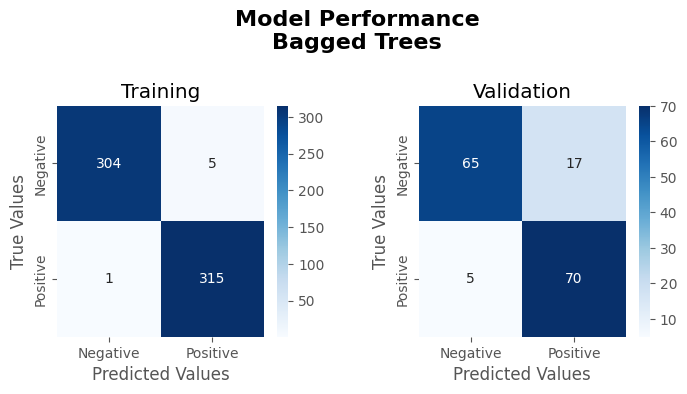

╔═══════════════════════════════════════════════════╗
║               TRAINING PERFORMANCE                ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       309
         1.0       0.98      1.00      0.99       316

    accuracy                           0.99       625
   macro avg       0.99      0.99      0.99       625
weighted avg       0.99      0.99      0.99       625

╔═══════════════════════════════════════════════════╗
║              VALIDATION PERFORMANCE               ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.93      0.79      0.86        82
         1.0       0.80      0.93      0.86        75

    accuracy                           0.86       157
   macro avg       0.87      0.86      0.86       157
weighted avg       0.87      0.86      0.86       157



In [38]:
show_train_val_confusion_matrix(train_y, train_pred_y, val_y, val_pred_y, "Model Performance\nBagged Trees", "../images/ModelDev_BaggedTrees_CM.png")

## 5. Random Forest<a id="forest"></a>

### 5.1. Hyperparamerters

In [39]:
params = {
    "n_estimators": np.arange(5, 25, 5),
    "max_depth": np.arange(2, 24, 2),
}

### 5.2. Model

In [40]:
clf = RandomForestClassifier(
    criterion="gini",  # Good for balanced data (we have already up-sampled out data so it is now balanced)
    class_weight="balanced",
    random_state=0     # Reproducible result
)

grid_clf = GridSearchCV(clf, params, cv=cv, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
grid_clf.fit(train_X, train_y.values.ravel())

train_pred_y = grid_clf.predict(train_X)
val_pred_y = grid_clf.predict(val_X)
clfs["forest"] = grid_clf

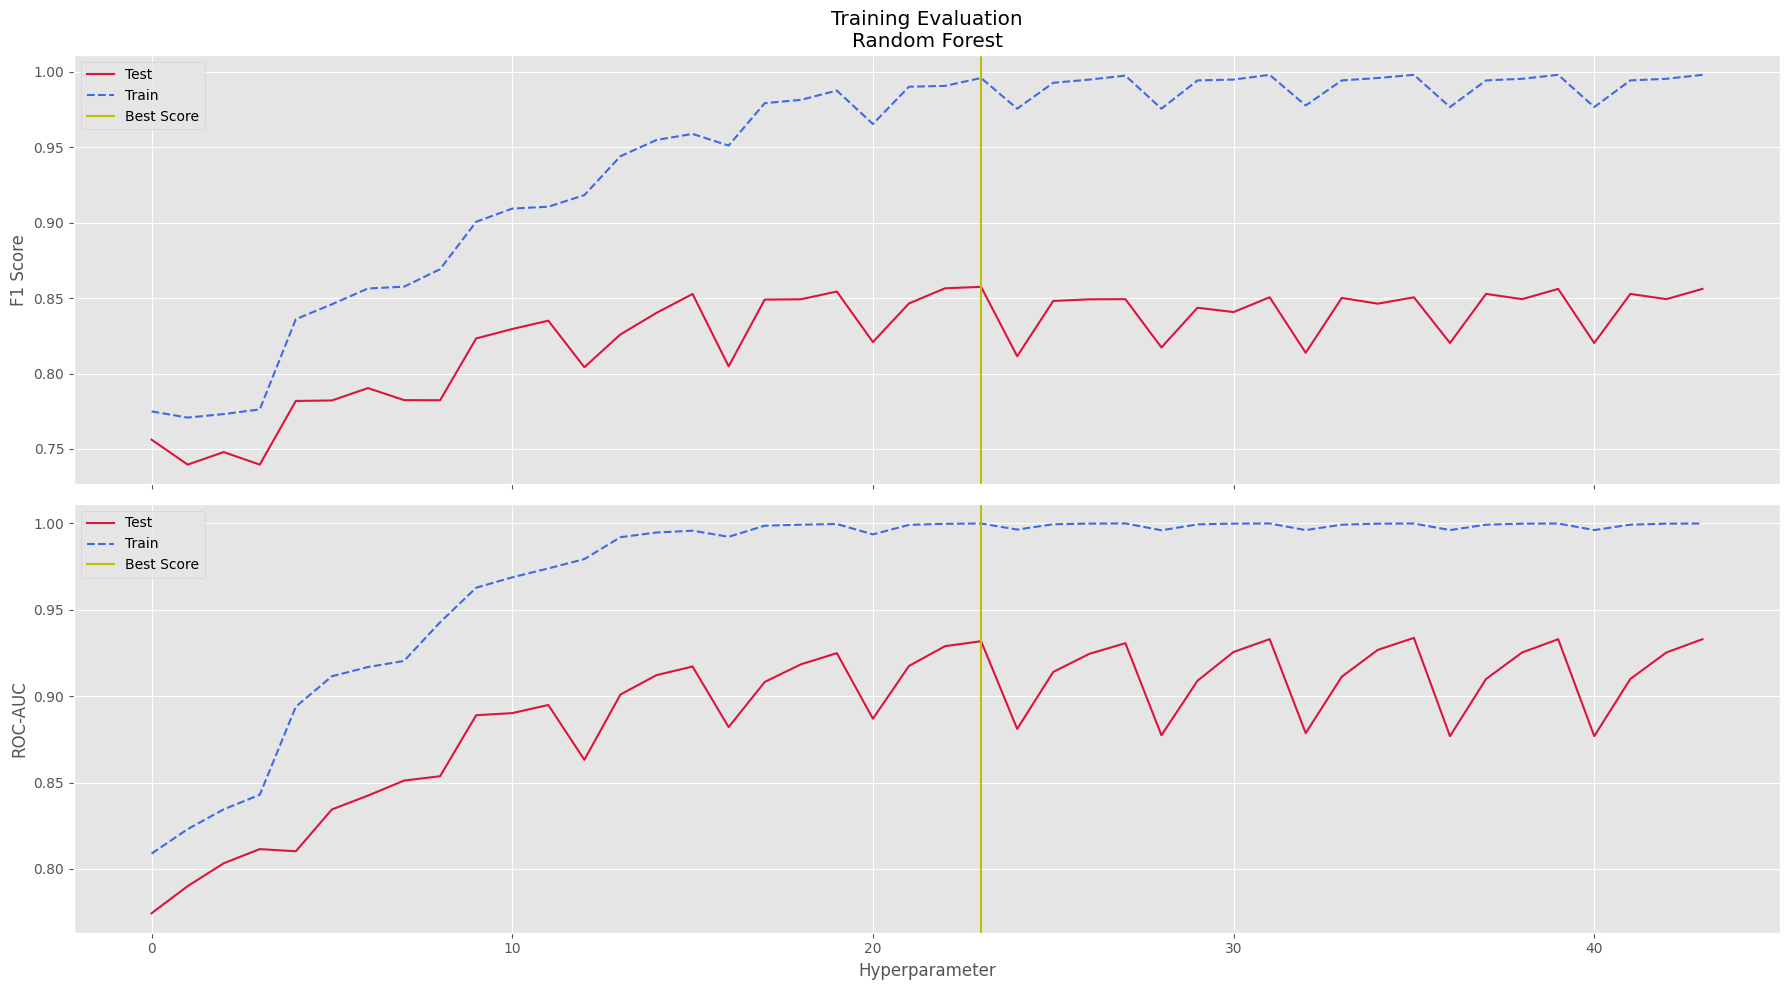

In [41]:
visualize_training(grid_clf, "Training Evaluation\nRandom Forest", "../images/ModelDev_RandomForest_TrainValCompare.png")

In [42]:
grid_clf.best_params_

{'max_depth': 12, 'n_estimators': 20}

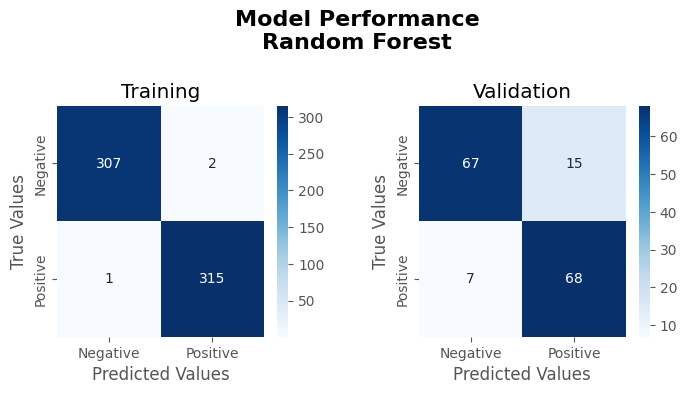

╔═══════════════════════════════════════════════════╗
║               TRAINING PERFORMANCE                ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       309
         1.0       0.99      1.00      1.00       316

    accuracy                           1.00       625
   macro avg       1.00      1.00      1.00       625
weighted avg       1.00      1.00      1.00       625

╔═══════════════════════════════════════════════════╗
║              VALIDATION PERFORMANCE               ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.91      0.82      0.86        82
         1.0       0.82      0.91      0.86        75

    accuracy                           0.86       157
   macro avg       0.86      0.86      0.86       157
weighted avg       0.86      0.86      0.86       157



In [43]:
show_train_val_confusion_matrix(train_y, train_pred_y, val_y, val_pred_y, "Model Performance\nRandom Forest", "../images/ModelDev_RandomForest_CM.png")